# Project

A rover has landed on Mars.

It knows its landing point and final destination but can only perceive its immediate surroundings. The objective is to reach the target while minimizing path length and energy consumption.

Environment:
- The terrain is modeled from a Mars DTM and simplified into a grid world, where each pixel corresponds to 1m. The rover, sized 1m×1m, occupies a single cell.
- The rover’s perception is limited to its local field of view. Using the DTM, visibility is computed in a 360° radius, restricted by terrain occlusions (e.g., it cannot see behind hills).

The task is approached using reinforcement learning with different techniques.

In [1]:
from torch import device
%load_ext autoreload
%autoreload 2

from custom_environment import GridMarsEnv
from hirise_dtm import HiriseDTM
from matplotlib import pyplot as plt
import numpy as np

## Digital Terrain Models (DTMs)

The HiRISE DTM is a 32-bit .IMG format. The .IMG is a PDS standard raster file format.

Data is taken from the [HiRISE Dataset](https://www.uahirise.org/dtm/).

HiRISE DTMs are created from two images of the same area, captured from different viewing angles. Their main advantage lies in the high resolution of the source images. The final product typically achieves a horizontal resolution of about 1–2 m/px and a vertical precision on the order of tens of centimeters. More info about DTM production can be found [here](https://www.uahirise.org/dtm/about.php).


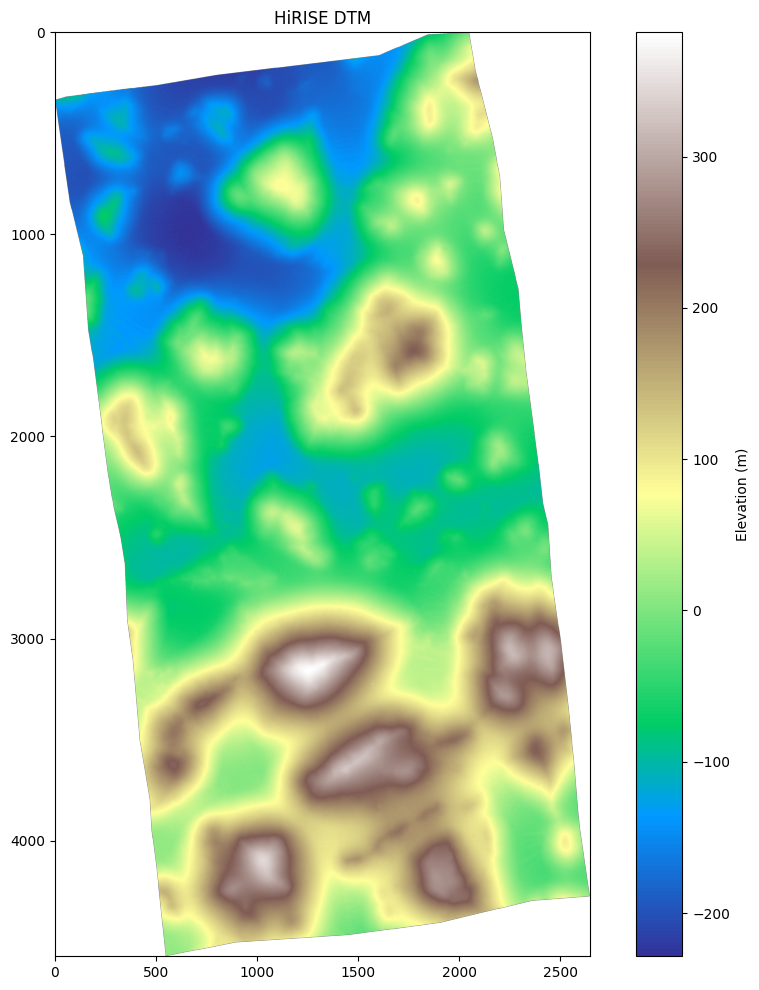

In [2]:
#filepath = "DTMs/DTEEC_016460_2230_016170_2230_G01.IMG"
filepath = "DTMs/DTEED_082989_1630_083055_1630_A01.IMG"
dtm_file = HiriseDTM(filepath)

dtm_file.plot_dtm()


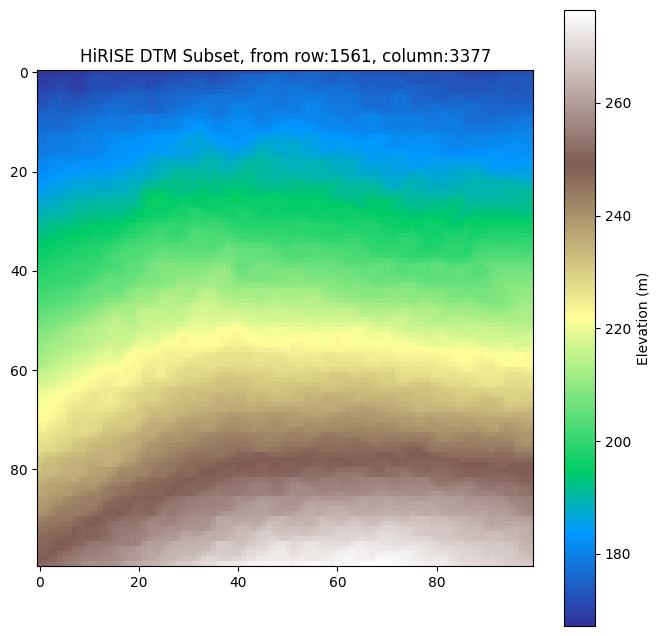

In [3]:
# portion of the map extraction
subset, position = dtm_file.get_portion_of_map(size=100)

plt.figure(figsize=(8,8))
plt.imshow(subset, cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.title(f"HiRISE DTM Subset, from row:{position[1]}, column:{position[0]}")
plt.show()

In [4]:
# the file metadata gives you information about the file. grid_spacing is the precision of the map. grid_spacing=1 means that 1px=1m^2
dtm_file.metadata


{'product_type': 'DTM',
 'file_type': 'Areoid Elevations',
 'projection': 'Equirectangular',
 'grid_spacing': 2,
 'orbit_and_latitude_1': ('082989', '1630'),
 'orbit_and_latitude_2': ('083055', '1630'),
 'producing_institution': 'University of Arizona',
 'version_number': '01'}

## Gymnasium Library

The [Gymnasium library](https://gymnasium.farama.org/index.html) is an open-source toolkit for reinforcement learning that provides a standard interface and a wide range of environments to develop, test, and benchmark RL algorithms. It allows to create your own custom environment.

[Here](https://gymnasium.farama.org/introduction/basic_usage/) you can find a small introduction to the library.

In [21]:
grid_mars_env = GridMarsEnv(dtm_file, render_mode="ascii", map_size=25, fov_distance=1, rover_max_drop=1, rover_max_step=1)
obs, info = grid_mars_env.reset(seed=11)


. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . * * * . . . . . . . . . . . . . . . . . . . . 
. . * A * . . . . . . . . . . . . . . . . . . . . 
. . * * * . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . T . . .

In [22]:
path = grid_mars_env.find_path()
grid_mars_env.render_ascii(path)

. . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . 
. . * * * . . . . . . . . . . . . . . . . . . . . 
. . * A * . . . . . . . . . . . . . . . . . . . . 
. . * * * . . . . . . . . . . . . . . . . . . . . 
. . . . + . . . . . . . . . . . . . . . . . . . . 
. . . . . + . . . . . . . . . . . . . . . . . . . 
. . . . . . + . . . . . . . . . . . . . . . . . . 
. . . . . . + . . . . . . . . . . . . . . . . . . 
. . . . . . . + . . . . . . . . . . . . . . . . . 
. . . . . . . . + . . . . . . . . . . . . . . . . 
. . . . . . . . . + . . . . . . . . . . . . . . . 
. . . . . . . . . + . . . . . . . . . . . . . . . 
. . . . . . . . . . + . . . . . . . . . . . . . . 
. . . . . . . . . . + . . . . . . . . . . . . . . 
. . . . . . . . . . . + . . . . . . . . . . . . . 
. . . . . . . . . . . + . . . . . . . . . . . . . 
. . . . . . . . . . . + . . . . . . . . . . . . . 
. . . . . . . . . . . . + . . . . . . . . . . . . 
. . . . . . . . . . . . T . . .

In [7]:
RIGHT = 0
DOWN = 1
LEFT = 2
UP = 3

RIGHT_DOWN = 4
LEFT_DOWN = 5
RIGHT_UP = 6
LEFT_UP = 7

observation, reward, terminated, truncated, info = grid_mars_env.step(LEFT, verbose=True)
#observation;

* * * . . . . . . . 
* A * . . . . . . . 
* * * . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . T . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Agent Position (y, x): [1 1]
This location was visited 2 times
Actions remained: 999
Action Selected: left
Movement allowed: False
Reward: -0.21000000000000002



## Test random per capire cose

In [8]:
import torch


def preprocess_observation(observation, device="cuda", return_type="torch"):
    agent_position = observation["agent"]
    target_position = observation["target"]

    local_map = observation["local_map"]
    local_map_mask = observation["local_map_mask"]
    visited_locations = observation["visited_locations"]
    map_shape = local_map.shape

    # Channel 0: altitude with mask
    channel_zero = np.array([
        [local_map[y, x] if local_map_mask[y, x] else np.nan
         for x in range(map_shape[1])]
        for y in range(map_shape[0])
    ], dtype=np.float32)

    # Channel 1: visited locations
    channel_one = visited_locations.astype(np.float32)

    # Channel 2: agent/target positions
    channel_two = np.zeros(map_shape, dtype=np.float32)
    channel_two[agent_position[0], agent_position[1]] = 1.0
    channel_two[target_position[0], target_position[1]] = -1.0

    # Stack channels
    x = np.stack([channel_zero, channel_one, channel_two], axis=0)  # (C, H, W)

    # Normalize channel 0 (altitude)
    altitude = x[0]
    mask = np.isnan(altitude)
    min_val = np.nanmin(altitude)
    max_val = np.nanmax(altitude)
    if min_val == max_val:
        x[0] = np.zeros_like(altitude)
    else:
        x[0] = (altitude - min_val) / (max_val - min_val)
    x[0][mask] = -1.0  # sentinel for NaN

    # Normalize channel 1 (visited locations)
    x[1] = np.log1p(x[1])

    # Convert to torch tensor and add batch dimension
    #return x
    return torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

ok = preprocess_observation(obs)
print(ok)


tensor([[[[ 1.0000,  0.4047,  0.0522, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [ 0.7228,  0.2211,  0.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [ 0.4166,  0.1899,  0.0089, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1

In [9]:
from policy_network import PolicyNetwork

config = {
           "input_channels": 3,
           "backbone": [
               {"type": "conv", "out_channels": 32, "kernel_size": 3, "stride": 1, "padding": 1, "activation": "relu"},
               {"type": "pool", "mode": "max", "kernel_size": 2},
               {"type": "conv", "out_channels": 64, "kernel_size": 3, "stride": 1, "padding": 1, "activation": "relu"},
               {"type": "pool", "mode": "max", "kernel_size": 2}
           ],
           "head_action": [
               {"type": "fc", "out_features": 128, "activation": "relu"},
               {"type": "fc", "out_features": 8}
           ],
           "head_value": [
               {"type": "fc", "out_features": 64, "activation": "relu"},
               {"type": "fc", "out_features": 1}
           ]
       }

policy_network = PolicyNetwork(config)

policy_network.to("cuda")
action_probs, value = policy_network(ok)

print(action_probs)
print(value)

tensor([[0.1238, 0.1300, 0.1304, 0.1236, 0.1236, 0.1177, 0.1307, 0.1202]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[-0.0409]], device='cuda:0', grad_fn=<AddmmBackward0>)
